In [10]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt

In [11]:
epochs = 10
batch_size = 50
classes = ["Back", "Bump", "Change", "Overtaking"]

In [12]:
def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

def frames_from_video_file(video_path, n_frames, output_size = (126, 224), frame_step=5):
    result = []
    src = cv2.VideoCapture(str(video_path))  
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, duration=300)
    
    return embed.embed_file('./animation.gif')

In [13]:
file_paths = []
targets = []
for i, c in enumerate(classes):
    sub_file_paths = os.listdir(f"vid/{c}")
    file_paths += [f"vid/{c}/" + i for i in sub_file_paths]
    targets += [i] * len(sub_file_paths)

    print(file_paths)

['vid/Back/bb_1_140822_vehicle_39_123.mp4', 'vid/Back/bb_1_141013_vehicle_187_030.mp4', 'vid/Back/bb_1_141026_vehicle_125_117.mp4', 'vid/Back/bb_1_141027_vehicle_200_51422.mp4', 'vid/Back/bb_1_141110_vehicle_110_142.mp4', 'vid/Back/bb_1_141124_vehicle_44_106.mp4', 'vid/Back/bb_1_150414_vehicle_141_167.mp4', 'vid/Back/bb_1_150513_vehicle_202_21918.mp4', 'vid/Back/bb_1_150516_vehicle_144_215.mp4', 'vid/Back/bb_1_150524_vehicle_253_53839.mp4', 'vid/Back/bb_1_150808_vehicle_29_336.mp4', 'vid/Back/bb_1_150818_vehicle_141_169.mp4', 'vid/Back/bb_1_151127_vehicle_239_27706.mp4', 'vid/Back/bb_1_160104_vehicle_202_22056.mp4', 'vid/Back/bb_1_160115_vehicle_217_21716.mp4', 'vid/Back/bb_1_160131_vehicle_148_069.mp4', 'vid/Back/bb_1_160203_vehicle_203_53983.mp4', 'vid/Back/bb_1_160213_vehicle_112_381.mp4', 'vid/Back/bb_1_160326_vehicle_29_346.mp4', 'vid/Back/bb_1_160402_vehicle_147_134.mp4', 'vid/Back/bb_1_160405_vehicle_113_067.mp4', 'vid/Back/bb_1_160417_vehicle_253_53799.mp4', 'vid/Back/bb_1_1605

In [14]:
file_paths

['vid/Back/bb_1_140822_vehicle_39_123.mp4',
 'vid/Back/bb_1_141013_vehicle_187_030.mp4',
 'vid/Back/bb_1_141026_vehicle_125_117.mp4',
 'vid/Back/bb_1_141027_vehicle_200_51422.mp4',
 'vid/Back/bb_1_141110_vehicle_110_142.mp4',
 'vid/Back/bb_1_141124_vehicle_44_106.mp4',
 'vid/Back/bb_1_150414_vehicle_141_167.mp4',
 'vid/Back/bb_1_150513_vehicle_202_21918.mp4',
 'vid/Back/bb_1_150516_vehicle_144_215.mp4',
 'vid/Back/bb_1_150524_vehicle_253_53839.mp4',
 'vid/Back/bb_1_150808_vehicle_29_336.mp4',
 'vid/Back/bb_1_150818_vehicle_141_169.mp4',
 'vid/Back/bb_1_151127_vehicle_239_27706.mp4',
 'vid/Back/bb_1_160104_vehicle_202_22056.mp4',
 'vid/Back/bb_1_160115_vehicle_217_21716.mp4',
 'vid/Back/bb_1_160131_vehicle_148_069.mp4',
 'vid/Back/bb_1_160203_vehicle_203_53983.mp4',
 'vid/Back/bb_1_160213_vehicle_112_381.mp4',
 'vid/Back/bb_1_160326_vehicle_29_346.mp4',
 'vid/Back/bb_1_160402_vehicle_147_134.mp4',
 'vid/Back/bb_1_160405_vehicle_113_067.mp4',
 'vid/Back/bb_1_160417_vehicle_253_53799.mp4'

In [ ]:
targets

(15, 126, 224, 3)



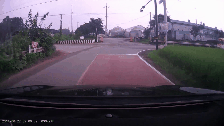

In [15]:
sample_video = frames_from_video_file(file_paths[0], n_frames=15)
print(sample_video.shape)
to_gif(sample_video)

In [16]:
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames=15))
features = np.array(features)

features

  0%|          | 0/408 [00:00<?, ?it/s]

array([[[[[7.07282901e-01, 6.56302512e-01, 8.52380991e-01],
          [7.15966403e-01, 6.64986014e-01, 8.61064494e-01],
          [7.27450967e-01, 6.76470578e-01, 8.72549057e-01],
          ...,
          [9.91316557e-01, 9.79551852e-01, 9.95238125e-01],
          [9.91316557e-01, 9.79551852e-01, 9.95238125e-01],
          [9.90476429e-01, 9.78711724e-01, 9.94397998e-01]],

         [[7.01400578e-01, 6.50420189e-01, 8.46498668e-01],
          [7.17647076e-01, 6.66666687e-01, 8.62745166e-01],
          [7.25490212e-01, 6.74509823e-01, 8.70588303e-01],
          ...,
          [9.92156923e-01, 9.80392218e-01, 9.96078491e-01],
          [9.88235354e-01, 9.76470649e-01, 9.92156923e-01],
          [9.89075482e-01, 9.77310777e-01, 9.92997050e-01]],

         [[7.09203660e-01, 6.58223271e-01, 8.54301751e-01],
          [7.18947589e-01, 6.67967200e-01, 8.64045680e-01],
          [7.29411781e-01, 6.70588255e-01, 8.70588303e-01],
          ...,
          [9.92156923e-01, 9.84313786e-01, 9.882353

In [17]:
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)
train_features.shape, val_features.shape, len(train_targets), len(val_targets)

((326, 15, 126, 224, 3), (82, 15, 126, 224, 3), 326, 82)

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(batch_size * 4).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [19]:
del train_features
del val_features
gc.collect()

216

In [20]:
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

(50, 15, 126, 224, 3) (50,)


In [21]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(15, 126, 224, 3)),
    tf.keras.layers.Conv3D(32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(len(classes), activation="softmax")
])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[
        "accuracy"
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 126, 224, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 63, 112, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 63, 112, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 31, 56, 64)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 31, 56, 128)    221312    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 15, 28, 128)   0

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_vid.h5", 
    monitor="val_accuracy",
    mode="max",
    save_best_only=True, 
    restore_best_weights=True
)
history = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=valid_ds, 
    callbacks=[checkpoint]
)
model.load_weights("model_vid.h5")

text = '''
Epoch 1/10
7/7 [==============================] - 564s 67s/step - loss: 1.3899 - accuracy: 0.2270 - val_loss: 1.3941 - val_accuracy: 0.2439
Epoch 2/10
7/7 [==============================] - 677s 85s/step - loss: 1.3781 - accuracy: 0.2761 - val_loss: 1.3863 - val_accuracy: 0.2439
Epoch 3/10
7/7 [==============================] - 677s 85s/step - loss: 1.3781 - accuracy: 0.2761 - val_loss: 1.3863 - val_accuracy: 0.2439
Epoch 4/10
7/7 [==============================] - 677s 85s/step - loss: 1.3781 - accuracy: 0.2761 - val_loss: 1.3863 - val_accuracy: 0.2439
Epoch 5/10
7/7 [==============================] - 677s 85s/step - loss: 1.3781 - accuracy: 0.2761 - val_loss: 1.3863 - val_accuracy: 0.2439
Epoch 6/10
7/7 [==============================] - 677s 85s/step - loss: 1.3781 - accuracy: 0.2761 - val_loss: 1.3863 - val_accuracy: 0.2439
Epoch 7/10
7/7 [==============================] - 677s 85s/step - loss: 1.3781 - accuracy: 0.2761 - val_loss: 1.3863 - val_accuracy: 0.2439
Epoch 8/10
7/7 [==============================] - 677s 85s/step - loss: 1.3781 - accuracy: 0.2761 - val_loss: 1.3863 - val_accuracy: 0.2439
Epoch 9/10
7/7 [==============================] - 677s 85s/step - loss: 1.3781 - accuracy: 0.2761 - val_loss: 1.3863 - val_accuracy: 0.2439
Epoch 10/10
7/7 [==============================] - 677s 85s/step - loss: 1.3781 - accuracy: 0.2761 - val_loss: 1.3863 - val_accuracy: 0.2439
'''

Epoch 1/10
7/7 [==============================] - 564s 67s/step - loss: 1.3899 - accuracy: 0.2270 - val_loss: 1.3941 - val_accuracy: 0.2439
Epoch 2/10
7/7 [==============================] - 677s 85s/step - loss: 1.3781 - accuracy: 0.2761 - val_loss: 1.3863 - val_accuracy: 0.2439
Epoch 3/10
7/7 [==============================] - 690s 101s/step - loss: 1.3665 - accuracy: 0.2761 - val_loss: 1.3744 - val_accuracy: 0.2805
Epoch 4/10
7/7 [==============================] - 653s 91s/step - loss: 1.3427 - accuracy: 0.3282 - val_loss: 1.3458 - val_accuracy: 0.3415
Epoch 5/10
7/7 [==============================] - 1624s 233s/step - loss: 1.2920 - accuracy: 0.4417 - val_loss: 1.3277 - val_accuracy: 0.3537
Epoch 6/10
7/7 [==============================] - 1500s 192s/step - loss: 1.2464 - accuracy: 0.4110 - val_loss: 1.3311 - val_accuracy: 0.3537
Epoch 7/10
7/7 [==============================] - 584s 88s/step - loss: 1.2052 - accuracy: 0.4264 - val_loss: 1.2971 - val_accuracy: 0.3780
Epoch 8/10
7/7 